In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [103]:
treasury_data = "treasury_quotes_2025-04-30.xlsx"

In [104]:
tabs = pd.ExcelFile(treasury_data).sheet_names 
tabs

['quotes', 'selected quotes']

# 1. Treasury Debt Composition

In [105]:
df = pd.read_excel(treasury_data, "quotes")

In [106]:
df.describe()

,KYTREASNO,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm,total size
count,449.000000,449.000000,398.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,396.000000,4.480000e+02
mean,207616.042316,6.907890,0.451134,2.591314,94.739339,94.784678,94.762008,0.639264,95.401272,0.040336,6.239472e+10
std,927.905288,8.228579,0.326784,1.714264,10.875317,10.853948,10.864615,0.653028,10.931811,0.004633,3.915569e+10
min,204085.000000,0.002738,0.000000,0.000000,48.640625,48.714844,48.677734,0.000000,49.250939,0.000000,8.810000e+09
25%,207361.000000,1.084189,0.163934,1.125000,93.406250,93.433594,93.419922,0.000000,93.723622,0.036599,4.196650e+10
50%,207905.000000,3.252567,0.408840,2.875000,98.925781,98.943894,98.942631,0.460981,99.190983,0.039217,5.269300e+10
75%,208228.000000,8.796715,0.829670,4.125000,100.570312,100.613281,100.585937,1.074176,101.481081,0.042967,7.027725e+10
max,208389.000000,29.796030,0.917127,6.875000,111.453125,111.523438,111.488281,2.980663,114.354303,0.048261,2.949850e+11


## 1.1

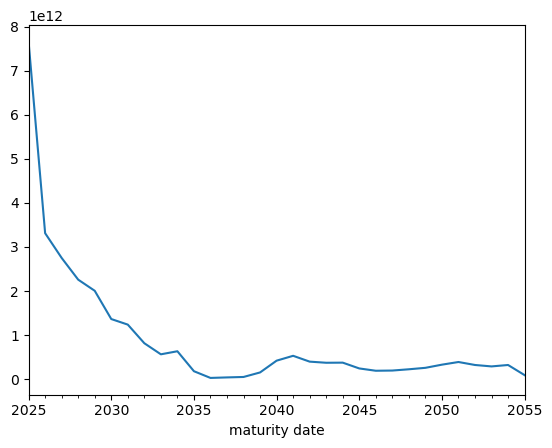

In [107]:
# 1. sum total size for each combination of maturity date & type
# For each maturity date, you can see the total sum of each type of treasury
# For maturity date - resmaple it by year (Y), by summing all trasuries maturity in that year
pivot_table_df = pd.pivot_table(df, values='total size', index='maturity date', aggfunc='sum', columns='type').resample('Y').sum()
# 2. Plot total debt by summing the values of all columns (treasury types) for each row (maturity year)
pivot_table_df.sum(axis=1).plot();

## 1.2

<AxesSubplot:xlabel='maturity date'>

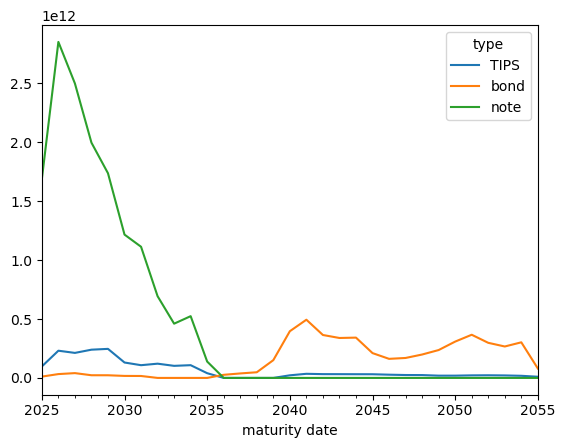

In [108]:
# Create TIPS col:
pivot_table_df["TIPS"] = pivot_table_df["TIPS bond"] + pivot_table_df["TIPS note"]
# Plot data:
pivot_table_df[["TIPS", "bond", "note"]].plot()

## 1.3

In [109]:
debts_by_type  = df.groupby('type')

total_debt_by_type = debts_by_type['total size'].sum()

total_debt_by_type

type
TIPS bond    5.738150e+11
TIPS note    1.453836e+12
bill         6.060022e+12
bond         4.957438e+12
note         1.490772e+13
Name: total size, dtype: float64

## 1.4

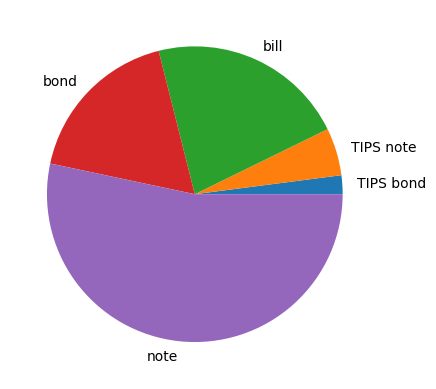

In [112]:
plt.pie(total_debt_by_type, labels = total_debt_by_type.index)
plt.show()

<AxesSubplot:xlabel='type'>

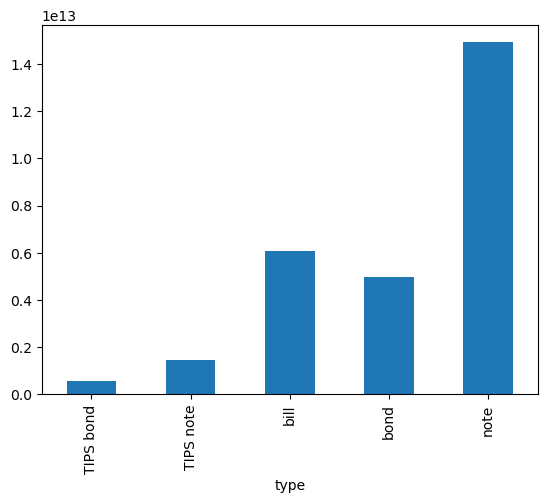

In [114]:
total_debt_by_type.plot(kind='bar')

## 1.5

In [126]:
df['_ttm'] = df['maturity date'] - df['quote date']
df['_ttm'].describe()

count                             449
mean     2523 days 02:33:56.525612480
std      3005 days 11:43:10.918794336
min                   1 days 00:00:00
25%                 396 days 00:00:00
50%                1188 days 00:00:00
75%                3213 days 00:00:00
max               10883 days 00:00:00
Name: _ttm, dtype: object

# 2 YTM and Price

In [90]:
from scipy.optimize import fsolve

## 2.1

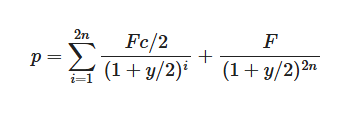

In [148]:
# Compute the price of bond:
# n is the number of years to maturity
# c is the coupon rate (a percentage)
# F is the face value, F = 100
# ytm is the YTM

def bond_price(n, c, ytm, F=100):
    price = 0
    
    for i in range(1, 2*n + 1):
       price += ((F*c/2)) / ((1 + ytm/2) ** i)
    
    price += (F) / ((1 + ytm/2) ** (2*n))
    
    return price

### 1

In [149]:
bond_price(n=30, c=3/100, ytm=5/100)

69.09134351494266

### 2

In [151]:
# F solve() finds root: value for which f(x) = 0

# Given: Actual price of the bond
# And we have the eqn to solve for the bond price
# They are equal i.e. plugging in values into the function should give us the price of the bond
# price_func = price => price_func - price = 0

def ytm_solver(y, n, c, actual_bond_price):
    return bond_price(n, c, y) - actual_bond_price

n = 30
c = 0.03
actual_bond_price = 87
    
starting_ytm_guess = 0.05 # can use any reasonable value. 5% because we know current treasuries have YTM btw 4.5 & 5.5

ytm_answer = fsolve(ytm_solver, starting_ytm_guess, args=(n, c, actual_bond_price))
ytm = ytm_answer[0]
ytm

0.03723106689117023

In [152]:
# Verify ytm:
price = bond_price(n, c, ytm)
price # Shoulbe be 87

86.99999999999982

## 2.2

In [154]:
df = pd.read_excel(treasury_data, "selected quotes")

In [158]:
def compute_ytm(row):
    
    starting_ytm_guess = 5/100 # Cheat: row['ytm']
    years_to_maturity = row['quote date'].year - row['maturity date'].year # Dont use ttm directly, we need year count (int)
    coupon_percent = row["cpn rate"] / 100

    return fsolve(
         ytm_solver, starting_ytm_guess, args=(years_to_maturity, coupon_percent, row["price"])
    )[0]


df["computed_ytm"] = df.apply(compute_ytm, axis=1)
df

C:\Users\DELL\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


,KYTREASNO,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm,total size,computed_ytm
0,208129,note,2025-04-30,2023-10-31,2025-10-31,0.503765,0.000000,5.000,100.402344,100.412129,100.407236,0.000000,100.407236,0.041371,46713000000,0.050000
1,208213,note,2025-04-30,2024-04-30,2026-04-30,0.999316,0.000000,4.875,100.931250,100.950766,100.941008,0.000000,100.941008,0.039086,69310000000,0.009388
2,208302,note,2025-04-30,2024-10-31,2026-10-31,1.503080,0.000000,4.125,100.570312,100.593750,100.582031,0.000000,100.582031,0.037147,70157000000,0.005812
3,208385,note,2025-04-30,2025-04-30,2027-04-30,1.998631,0.000000,3.750,100.292969,100.296875,100.294922,0.000000,100.294922,0.035981,73725000000,0.001473
4,207960,note,2025-04-30,2022-10-31,2027-10-31,2.502396,0.000000,4.125,101.269531,101.296875,101.283203,0.000000,101.283203,0.035803,43000000000,0.006385
5,208044,note,2025-04-30,2023-04-30,2028-04-30,3.000684,0.000000,3.500,99.726562,99.753906,99.740234,0.000000,99.740234,0.035912,47183000000,-0.000867
6,208132,note,2025-04-30,2023-10-31,2028-10-31,3.504449,0.000000,4.875,104.042969,104.082031,104.062500,0.000000,104.062500,0.036240,51999000000,0.013318
7,208216,note,2025-04-30,2024-04-30,2029-04-30,4.000000,0.000000,4.625,103.539062,103.578125,103.558594,0.000000,103.558594,0.036603,70332000000,0.008761
8,208305,note,2025-04-30,2024-10-31,2029-10-31,4.503765,0.000000,4.125,101.765625,101.804688,101.785156,0.000000,101.785156,0.036877,71181000000,0.004428
9,208388,note,2025-04-30,2025-04-30,2030-04-30,4.999316,0.000000,3.875,100.710938,100.718750,100.714844,0.000000,100.714844,0.037173,74794000000,0.001425


In [159]:
df[['computed_ytm', 'ytm']].corr(method="pearson") # Values not very close, and have poor correlation, I think I made an error

,computed_ytm,ytm
computed_ytm,1.000000,0.160681
ytm,0.160681,1.000000


<AxesSubplot:xlabel='ttm'>

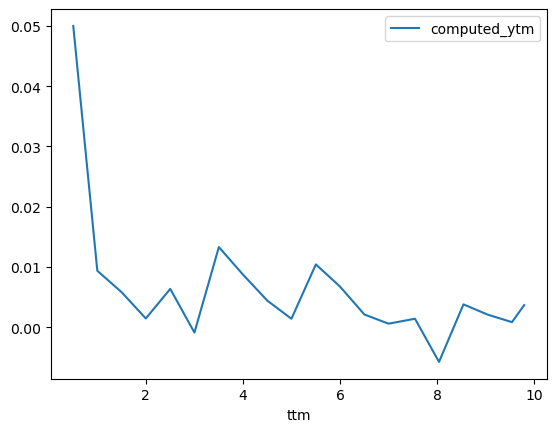

In [160]:
df.plot(x='ttm', y='computed_ytm')